<a href="https://colab.research.google.com/github/maulanaakbardj/Home-Agriculture-Monitoring-System/blob/main/ML/notebook/leaf_classification_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing the Data-set

In [ ]:
! git clone https://github.com/maulanaakbardj/Home-Agriculture-Monitoring-System

Cloning into 'Home-Agriculture-Monitoring-System'...
remote: Enumerating objects: 57209, done.
remote: Counting objects: 100% (1548/1548), done.
remote: Compressing objects: 100% (1357/1357), done.
remote: Total 57209 (delta 183), reused 1456 (delta 141), pack-reused 55661
Receiving objects: 100% (57209/57209), 2.07 GiB | 36.82 MiB/s, done.
Resolving deltas: 100% (226/226), done.
Checking out files: 100% (96517/96517), done.


# Import the required libraries

In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Grape leaf classification

## Prepare the training data

In [ ]:
data1_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Anggur'


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data1_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data1_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 7222 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 4))

In [ ]:
print (train_generator.class_indices)

labels1 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsAnggur.txt', 'w') as f:
  f.write(labels1)

{'Busuk Hitam': 0, 'Esca (Campak hitam)': 1, 'Hawar Daun (Bercak Daun Isariopsis)': 2, 'Sehat': 3}


In [ ]:
!cat /content/drive/MyDrive/model_project/labelsAnggur.txt

Busuk Hitam
Esca (Campak hitam)
Hawar Daun (Bercak Daun Isariopsis)
Sehat

## Build the model, Create the base model

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


## Add a classification head

In [ ]:
model1 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=4, activation='softmax')
])

## Configure the model

In [ ]:
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable weights = {}'.format(len(model1.trainable_weights)))

Number of trainable weights = 4


## Train the model

In [ ]:
history = model1.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
113/113 [==============================] - 59s 225ms/step - loss: 0.3455 - accuracy: 0.8856 - val_loss: 0.0533 - val_accuracy: 0.9839
Epoch 2/10
113/113 [==============================] - 20s 180ms/step - loss: 0.0344 - accuracy: 0.9882 - val_loss: 0.0468 - val_accuracy: 0.9828
Epoch 3/10
113/113 [==============================] - 20s 179ms/step - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.0995 - val_accuracy: 0.9684
Epoch 4/10
113/113 [==============================] - 20s 179ms/step - loss: 0.0191 - accuracy: 0.9929 - val_loss: 0.0498 - val_accuracy: 0.9878
Epoch 5/10
113/113 [==============================] - 20s 178ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.0798 - val_accuracy: 0.9723
Epoch 6/10
113/113 [==============================] - 20s 178ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0557 - val_accuracy: 0.9850
Epoch 7/10
113/113 [==============================] - 20s 178ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0453 - val_ac

## Review the learning curves

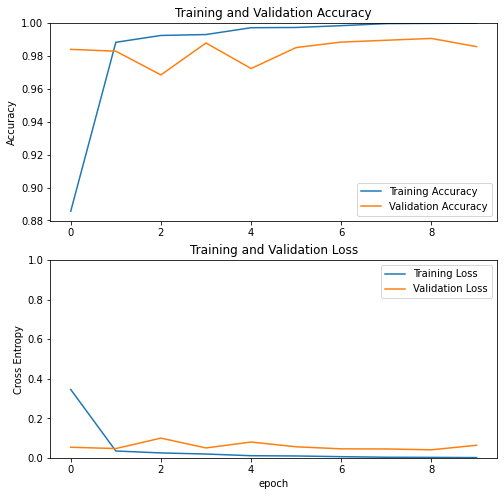

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,230,244
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
print('Number of trainable weights = {}'.format(len(model1.trainable_weights)))

Number of trainable weights = 58


## Continue training

In [ ]:
history_fine = model1.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
113/113 [==============================] - 25s 197ms/step - loss: 0.3898 - accuracy: 0.9290 - val_loss: 0.0403 - val_accuracy: 0.9917
Epoch 2/5
113/113 [==============================] - 21s 186ms/step - loss: 0.0668 - accuracy: 0.9810 - val_loss: 0.0483 - val_accuracy: 0.9900
Epoch 3/5
113/113 [==============================] - 21s 189ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.0580 - val_accuracy: 0.9884
Epoch 4/5
113/113 [==============================] - 21s 189ms/step - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0488 - val_accuracy: 0.9900
Epoch 5/5
113/113 [==============================] - 22s 192ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0511 - val_accuracy: 0.9889


## Review the new learning curves

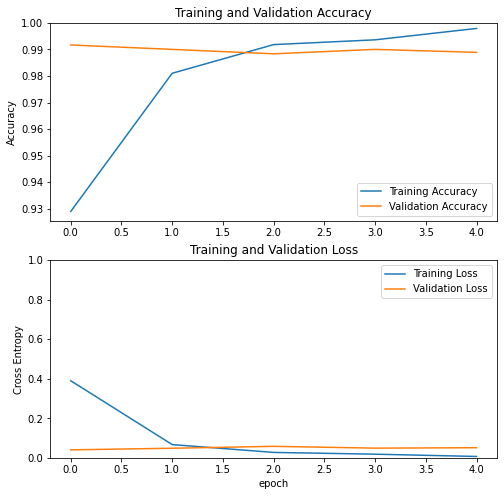

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:

MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Anggur.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model1.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Anggur.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data1_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model1)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Anggur_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpuiqdwcay/assets


INFO:tensorflow:Assets written to: /tmp/tmpuiqdwcay/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model1(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 100.000%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Anggur_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 100.000%


# 2. Apple leaf classification

## Prepare the training data

In [ ]:
data2_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Apel'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data2_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data2_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 4))

In [ ]:
print (train_generator.class_indices)

labels2 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsApel.txt', 'w') as f:
  f.write(labels2)

{'Busuk Hitam': 0, 'Karat Apel Cedar': 1, 'Keropeng Apel': 2, 'Sehat': 3}


In [ ]:
!cat /content/drive/MyDrive/model_project/labelsApel.txt

Busuk Hitam
Karat Apel Cedar
Keropeng Apel
Sehat

## Add a classification head

In [ ]:
model2 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=4, activation='softmax')
])

## Configure the model

In [ ]:
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,230,244
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
print('Number of trainable weights = {}'.format(len(model2.trainable_weights)))

Number of trainable weights = 58


## Train the model

In [ ]:
history = model2.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
40/40 [==============================] - 13s 263ms/step - loss: 0.3623 - accuracy: 0.8971 - val_loss: 5.8720 - val_accuracy: 0.6420
Epoch 2/10
40/40 [==============================] - 8s 191ms/step - loss: 0.0408 - accuracy: 0.9874 - val_loss: 8.4840 - val_accuracy: 0.6625
Epoch 3/10
40/40 [==============================] - 8s 187ms/step - loss: 0.0365 - accuracy: 0.9929 - val_loss: 6.2396 - val_accuracy: 0.7445
Epoch 4/10
40/40 [==============================] - 8s 189ms/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 2.9984 - val_accuracy: 0.7965
Epoch 5/10
40/40 [==============================] - 8s 187ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 1.9647 - val_accuracy: 0.8155
Epoch 6/10
40/40 [==============================] - 8s 187ms/step - loss: 0.0222 - accuracy: 0.9941 - val_loss: 4.5032 - val_accuracy: 0.7445
Epoch 7/10
40/40 [==============================] - 8s 187ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 5.4147 - val_accuracy: 0.7240
Epoch

## Review the learning curves

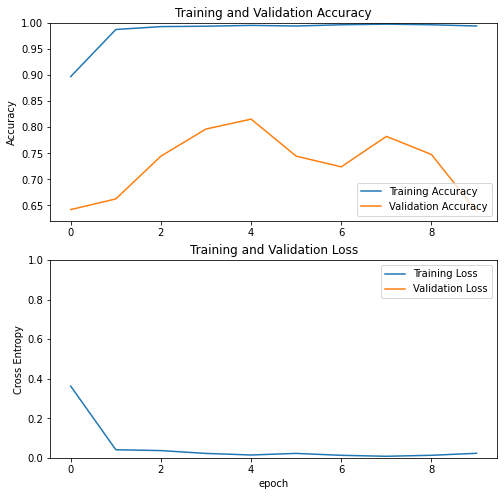

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print('Number of trainable weights = {}'.format(len(model2.trainable_weights)))

Number of trainable weights = 58


## Continue training

In [ ]:
history_fine = model2.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
40/40 [==============================] - 11s 209ms/step - loss: 0.0334 - accuracy: 0.9941 - val_loss: 5.2501 - val_accuracy: 0.6830
Epoch 2/5
40/40 [==============================] - 8s 190ms/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 4.5015 - val_accuracy: 0.7224
Epoch 3/5
40/40 [==============================] - 8s 188ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 3.7095 - val_accuracy: 0.7555
Epoch 4/5
40/40 [==============================] - 8s 188ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 3.0709 - val_accuracy: 0.7886
Epoch 5/5
40/40 [==============================] - 8s 190ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 2.5699 - val_accuracy: 0.8107


## Review the new learning curves

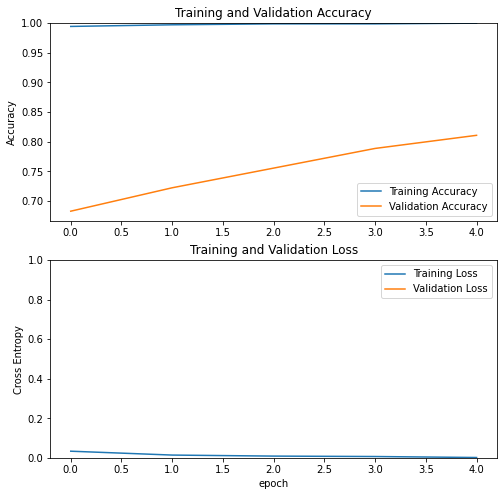

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Apel.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model2.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Apel.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data2_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model2)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Apel_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp4bbgjvsn/assets


INFO:tensorflow:Assets written to: /tmp/tmp4bbgjvsn/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model2(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 78.125%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Apel_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 87.500%


# 3. Leaf classification

## Prepare the training data

In [ ]:
data3_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Daun'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data3_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data3_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 44361 images belonging to 22 classes.
Found 11081 images belonging to 22 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 22))

In [ ]:
print (train_generator.class_indices)

labels3 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsDaun.txt', 'w') as f:
  f.write(labels3)

{'Bercak Bakteri': 0, 'Bercak Daun Abu-Abu': 1, 'Bercak Daun Coklat': 2, 'Bercak Daun Target Spot': 3, 'Bercak Kering Alternaria': 4, 'Bintik daun Septoria': 5, 'Busuk Hitam': 6, 'Esca (Campak hitam)': 7, 'Hangus Daun': 8, 'Hawar Daun': 9, 'Hawar Daun (Bercak Daun Isariopsis)': 10, 'Hawar Daun Bakteri': 11, 'Jamur tepung': 12, 'Kapang Daun': 13, 'Karat Apel Cedar': 14, 'Karat Daun': 15, 'Keropeng Apel': 16, 'Sehat': 17, 'Smut Daun': 18, 'Tungau Laba laba Spider Mite': 19, 'Virus Kuning Keriting': 20, 'Virus Mosaik': 21}


In [ ]:
!cat /content/drive/MyDrive/model_project/labelsDaun.txt

Bercak Bakteri
Bercak Daun Abu-Abu
Bercak Daun Coklat
Bercak Daun Target Spot
Bercak Kering Alternaria
Bintik daun Septoria
Busuk Hitam
Esca (Campak hitam)
Hangus Daun
Hawar Daun
Hawar Daun (Bercak Daun Isariopsis)
Hawar Daun Bakteri
Jamur tepung
Kapang Daun
Karat Apel Cedar
Karat Daun
Keropeng Apel
Sehat
Smut Daun
Tungau Laba laba Spider Mite
Virus Kuning Keriting
Virus Mosaik

## Add a classification head

In [ ]:
model3 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=22, activation='softmax')
])

## Configure the model

In [ ]:
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                726       
Total params: 2,627,382
Trainable params: 2,230,838
Non-trainable params: 396,544
_________________________________________________________________


## Train the model

In [ ]:
history = model3.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
694/694 [==============================] - 158s 223ms/step - loss: 0.3425 - accuracy: 0.8996 - val_loss: 3.7549 - val_accuracy: 0.5106
Epoch 2/10
694/694 [==============================] - 134s 193ms/step - loss: 0.1124 - accuracy: 0.9656 - val_loss: 1.4970 - val_accuracy: 0.7429
Epoch 3/10
694/694 [==============================] - 133s 191ms/step - loss: 0.0738 - accuracy: 0.9770 - val_loss: 0.9187 - val_accuracy: 0.8451
Epoch 4/10
694/694 [==============================] - 132s 191ms/step - loss: 0.0587 - accuracy: 0.9817 - val_loss: 1.0140 - val_accuracy: 0.8245
Epoch 5/10
694/694 [==============================] - 132s 191ms/step - loss: 0.0462 - accuracy: 0.9857 - val_loss: 0.7770 - val_accuracy: 0.8719
Epoch 6/10
694/694 [==============================] - 132s 190ms/step - loss: 0.0457 - accuracy: 0.9865 - val_loss: 1.2384 - val_accuracy: 0.7967
Epoch 7/10
694/694 [==============================] - 132s 191ms/step - loss: 0.0423 - accuracy: 0.9871 - val_loss: 1.8438 -

## Review the learning curves

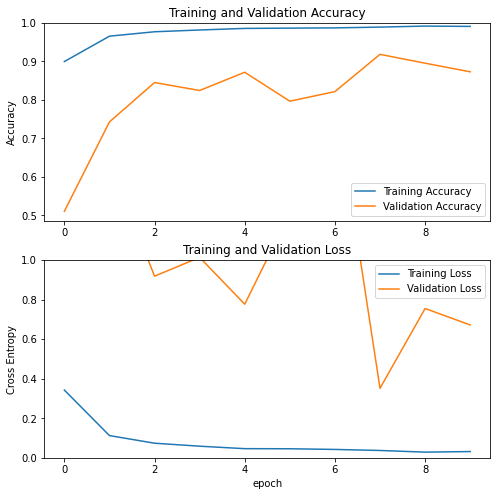

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Continue training

In [ ]:
history_fine = model3.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
694/694 [==============================] - 136s 191ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.1054 - val_accuracy: 0.9732
Epoch 2/5
694/694 [==============================] - 131s 189ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 3/5
694/694 [==============================] - 131s 189ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 4/5
694/694 [==============================] - 132s 190ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 5/5
694/694 [==============================] - 132s 190ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0341 - val_accuracy: 0.9895


## Review the new learning curves

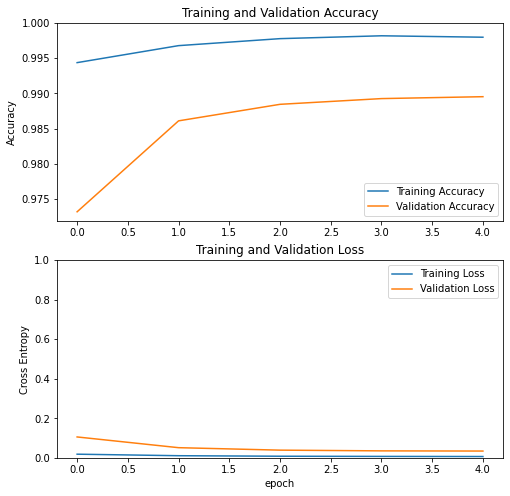

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Daun.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model3.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Daun.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data3_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model3)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Daun_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp8y7sxdub/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y7sxdub/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model3(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 100.000%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Daun_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 100.000%


# 4. Corn leaf classification

## Prepare the training data

In [ ]:
data4_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Jagung'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data4_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data4_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 7318 images belonging to 4 classes.
Found 1827 images belonging to 4 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 4))

In [ ]:
print (train_generator.class_indices)

labels4 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsJagung.txt', 'w') as f:
  f.write(labels4)

{'Bercak Daun Abu-Abu': 0, 'Hawar Daun': 1, 'Karat Daun': 2, 'Sehat': 3}


In [ ]:
!cat /content/drive/MyDrive/model_project/labelsJagung.txt

Bercak Daun Abu-Abu
Hawar Daun
Karat Daun
Sehat

## Add a classification head

In [ ]:
model4 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=4, activation='softmax')
])

## Configure the model

In [ ]:
model4.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model4.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
115/115 [==============================] - 29s 225ms/step - loss: 0.0568 - accuracy: 0.9817 - val_loss: 0.4248 - val_accuracy: 0.9683
Epoch 2/10
115/115 [==============================] - 21s 183ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.1257 - val_accuracy: 0.9792
Epoch 3/10
115/115 [==============================] - 21s 184ms/step - loss: 0.0211 - accuracy: 0.9940 - val_loss: 0.6038 - val_accuracy: 0.9305
Epoch 4/10
115/115 [==============================] - 21s 183ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 0.1463 - val_accuracy: 0.9759
Epoch 5/10
115/115 [==============================] - 21s 184ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.1923 - val_accuracy: 0.9803
Epoch 6/10
115/115 [==============================] - 21s 183ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.5411 - val_accuracy: 0.9414
Epoch 7/10
115/115 [==============================] - 21s 183ms/step - loss: 0.0092 - accuracy: 0.9990 - val_loss: 0.4399 - val_ac

## Review the learning curves

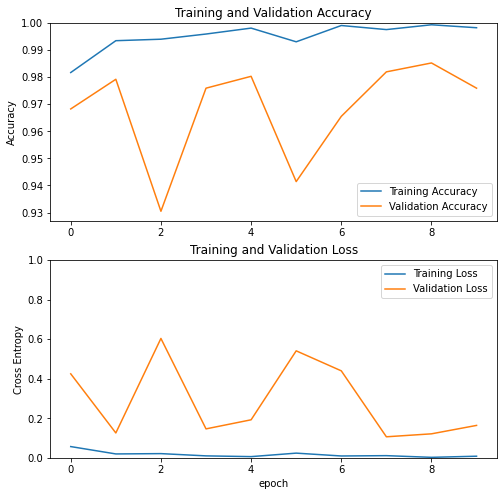

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Continue training

In [ ]:
history_fine = model4.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
115/115 [==============================] - 26s 190ms/step - loss: 0.0285 - accuracy: 0.9943 - val_loss: 0.1373 - val_accuracy: 0.9803
Epoch 2/5
115/115 [==============================] - 21s 183ms/step - loss: 0.0167 - accuracy: 0.9955 - val_loss: 0.1177 - val_accuracy: 0.9819
Epoch 3/5
115/115 [==============================] - 21s 183ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.1083 - val_accuracy: 0.9808
Epoch 4/5
115/115 [==============================] - 21s 183ms/step - loss: 0.0107 - accuracy: 0.9982 - val_loss: 0.1000 - val_accuracy: 0.9814
Epoch 5/5
115/115 [==============================] - 21s 183ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0940 - val_accuracy: 0.9819


## Review the new learning curves

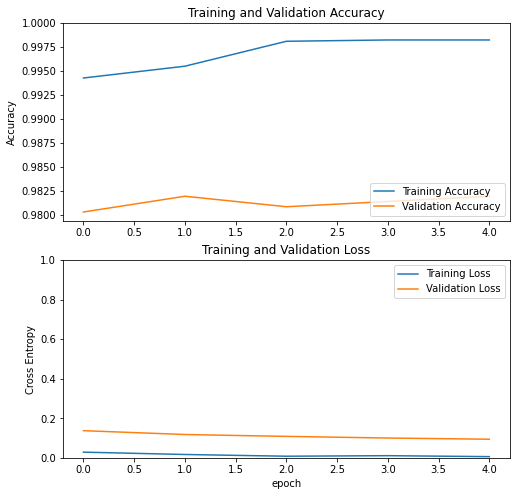

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Jagung.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model4.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Jagung.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data4_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model4)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Jagung_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp9fx_ajal/assets


INFO:tensorflow:Assets written to: /tmp/tmp9fx_ajal/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model4(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 98.438%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Jagung_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 98.438%


# 5. Potato leaf classification

## Prepare the training data

In [ ]:
data5_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Kentang'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data5_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data5_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 3))

In [ ]:
print (train_generator.class_indices)

labels5 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsKentang.txt', 'w') as f:
  f.write(labels5)

{'Bercak Kering Alternaria': 0, 'Hawar Daun': 1, 'Sehat': 2}


## Add a classification head

In [ ]:
model5 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=3, activation='softmax')
])

## Configure the model

In [ ]:
model5.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model5.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
27/27 [==============================] - 10s 277ms/step - loss: 0.4642 - accuracy: 0.8641 - val_loss: 0.8676 - val_accuracy: 0.8326
Epoch 2/10
27/27 [==============================] - 5s 191ms/step - loss: 0.0812 - accuracy: 0.9692 - val_loss: 0.5178 - val_accuracy: 0.8698
Epoch 3/10
27/27 [==============================] - 5s 192ms/step - loss: 0.0730 - accuracy: 0.9303 - val_loss: 0.5635 - val_accuracy: 0.8558
Epoch 4/10
27/27 [==============================] - 5s 192ms/step - loss: 0.0659 - accuracy: 0.9315 - val_loss: 0.3638 - val_accuracy: 0.8977
Epoch 5/10
27/27 [==============================] - 5s 192ms/step - loss: 0.0546 - accuracy: 0.9518 - val_loss: 0.4253 - val_accuracy: 0.9116
Epoch 6/10
27/27 [==============================] - 5s 192ms/step - loss: 0.0399 - accuracy: 0.9965 - val_loss: 2.4434 - val_accuracy: 0.7884
Epoch 7/10
27/27 [==============================] - 5s 194ms/step - loss: 0.0546 - accuracy: 0.9919 - val_loss: 10.9338 - val_accuracy: 0.5907
Epoc

## Review the learning curves

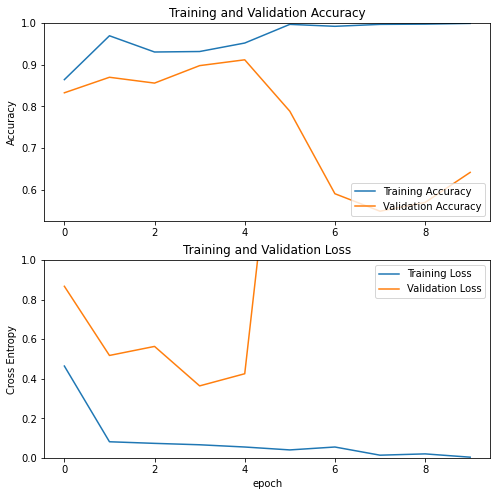

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model5.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Continue training

In [ ]:
history_fine = model5.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
27/27 [==============================] - 9s 229ms/step - loss: 0.0097 - accuracy: 0.9988 - val_loss: 14.4912 - val_accuracy: 0.6535
Epoch 2/5
27/27 [==============================] - 5s 199ms/step - loss: 0.0227 - accuracy: 0.9959 - val_loss: 13.0098 - val_accuracy: 0.6698
Epoch 3/5
27/27 [==============================] - 5s 199ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 11.3670 - val_accuracy: 0.6860
Epoch 4/5
27/27 [==============================] - 5s 198ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 9.8212 - val_accuracy: 0.6953
Epoch 5/5
27/27 [==============================] - 5s 196ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.4276 - val_accuracy: 0.7233


## Review the new learning curves

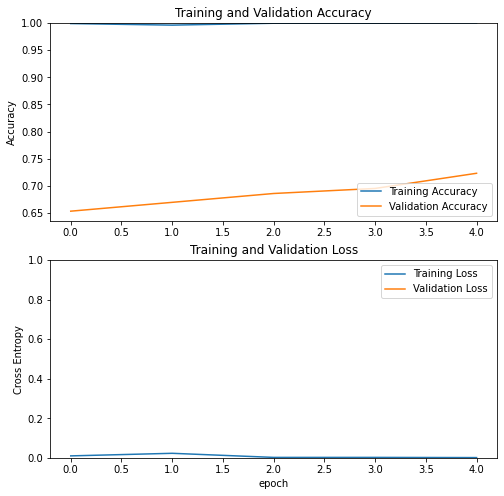

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Kentang.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model5.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Kentang.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data5_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model5)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Kentang_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpi_w3e4xl/assets


INFO:tensorflow:Assets written to: /tmp/tmpi_w3e4xl/assets


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model5(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 70.312%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Kentang_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 65.625%


# 6. Rice leaf classification

## Prepare the training data

In [ ]:
data6_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Padi'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data6_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data6_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((24, 224, 224, 3), (24, 3))

In [ ]:
print (train_generator.class_indices)

labels6 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsPadi.txt', 'w') as f:
  f.write(labels6)

{'Bercak Daun Coklat': 0, 'Hawar Daun Bakteri': 1, 'Smut Daun': 2}


## Add a classification head

In [ ]:
model6 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=3, activation='softmax')
])

## Configure the model

In [ ]:
model6.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model6.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
2/2 [==============================] - 8s 4s/step - loss: 1.8043 - accuracy: 0.3125 - val_loss: 2.6118 - val_accuracy: 0.3750
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 1.0963 - accuracy: 0.6354 - val_loss: 3.6003 - val_accuracy: 0.4167
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.4929 - accuracy: 0.7917 - val_loss: 4.4749 - val_accuracy: 0.4583
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.5007 - accuracy: 0.7708 - val_loss: 5.7451 - val_accuracy: 0.4583
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.3553 - accuracy: 0.8438 - val_loss: 6.7402 - val_accuracy: 0.4583
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.1540 - accuracy: 0.9479 - val_loss: 7.1762 - val_accuracy: 0.4583
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.1447 - accuracy: 0.9375 - val_loss: 7.0702 - val_accuracy: 0.4583
Epoch 8/10
2/2 [=========================

## Review the learning curves

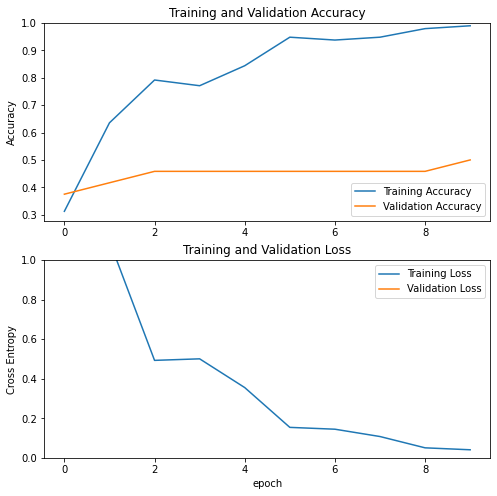

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model6.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Continue training

In [ ]:
history_fine = model6.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
2/2 [==============================] - 7s 3s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 5.6080 - val_accuracy: 0.5417
Epoch 2/5
2/2 [==============================] - 3s 2s/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 5.5939 - val_accuracy: 0.5417
Epoch 3/5
2/2 [==============================] - 3s 2s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 5.5790 - val_accuracy: 0.5417
Epoch 4/5
2/2 [==============================] - 3s 1s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 5.5640 - val_accuracy: 0.5417
Epoch 5/5
2/2 [==============================] - 3s 1s/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 5.5505 - val_accuracy: 0.5417


## Review the new learning curves

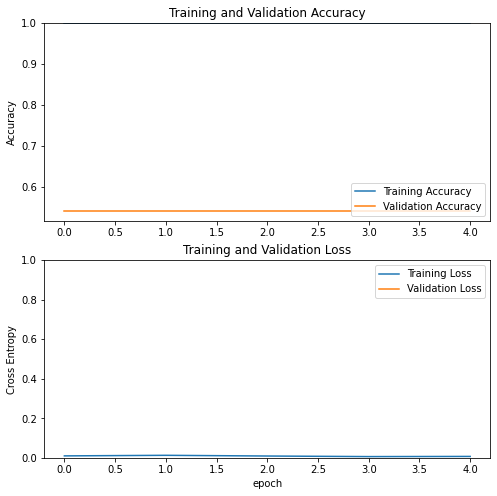

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Padi.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model6.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Padi.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data6_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model6)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Padi_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpxwo8xgde/assets


INFO:tensorflow:Assets written to: /tmp/tmpxwo8xgde/assets


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model6(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 54.167%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Padi_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 58.333%


# 7. Tomato leaf classification

## Prepare the training data

In [ ]:
data7_dir ='/content/Home-Agriculture-Monitoring-System/ML/Data/Tomat'

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data7_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data7_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 10))

In [ ]:
print (train_generator.class_indices)

labels7 = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/model_project/labelsTomat.txt', 'w') as f:
  f.write(labels7)

{'Bercak Bakteri': 0, 'Bercak Daun Target Spot': 1, 'Bercak Kering Alternaria': 2, 'Bintik daun Septoria': 3, 'Hawar Daun': 4, 'Kapang Daun': 5, 'Sehat': 6, 'Tungau Laba laba Spider Mite': 7, 'Virus Kuning Keriting': 8, 'Virus Mosaik': 9}


## Add a classification head

In [ ]:
model7 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=10, activation='softmax')
])

## Configure the model

In [ ]:
model7.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model7.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
201/201 [==============================] - 49s 222ms/step - loss: 0.1676 - accuracy: 0.9490 - val_loss: 0.7894 - val_accuracy: 0.8021
Epoch 2/10
201/201 [==============================] - 38s 188ms/step - loss: 0.0406 - accuracy: 0.9886 - val_loss: 1.8287 - val_accuracy: 0.6717
Epoch 3/10
201/201 [==============================] - 38s 187ms/step - loss: 0.0324 - accuracy: 0.9906 - val_loss: 0.5511 - val_accuracy: 0.9046
Epoch 4/10
201/201 [==============================] - 38s 187ms/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.4827 - val_accuracy: 0.9124
Epoch 5/10
201/201 [==============================] - 38s 188ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.1368 - val_accuracy: 0.9644
Epoch 6/10
201/201 [==============================] - 38s 187ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.2085 - val_accuracy: 0.9550
Epoch 7/10
201/201 [==============================] - 38s 188ms/step - loss: 0.0177 - accuracy: 0.9955 - val_loss: 0.4293 - val_ac

## Review the learning curves

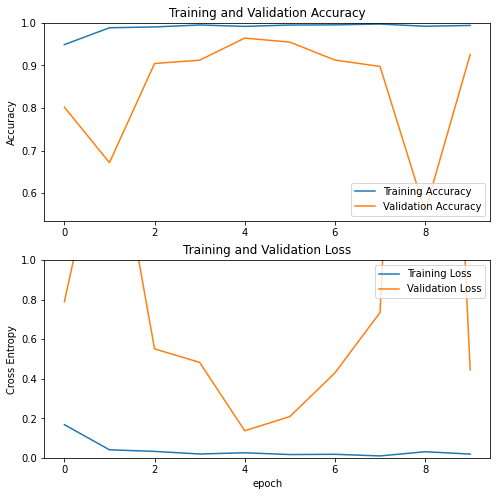

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model, Un-freeze more layers

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Reconfigure the model

In [ ]:
model7.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Continue training

In [ ]:
history_fine = model7.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
201/201 [==============================] - 41s 191ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.2500 - val_accuracy: 0.9547
Epoch 2/5
201/201 [==============================] - 38s 187ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.1747 - val_accuracy: 0.9650
Epoch 3/5
201/201 [==============================] - 38s 187ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.1331 - val_accuracy: 0.9734
Epoch 4/5
201/201 [==============================] - 38s 187ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.1119 - val_accuracy: 0.9775
Epoch 5/5
201/201 [==============================] - 38s 188ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.1005 - val_accuracy: 0.9790


## Review the new learning curves

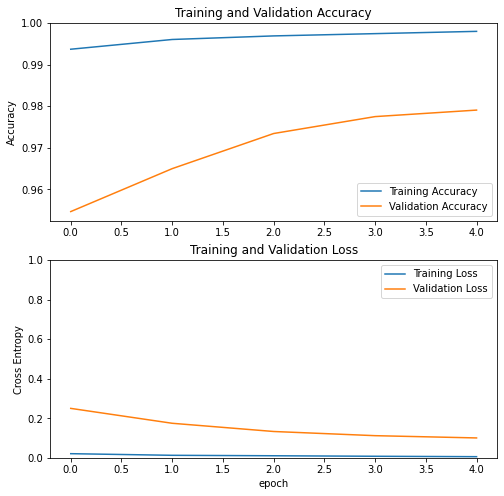

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save Model

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "Tomat.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model7.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/Tomat.h5...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Convert to TFLite

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data7_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model6)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/Tomat_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp2nd8cd_v/assets


INFO:tensorflow:Assets written to: /tmp/tmp2nd8cd_v/assets


## Compare the accuracy

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model7(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 96.875%


In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/model_project/Tomat_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 3.125%
